In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
texture_1 = plt.imread('../data/texture1.jpg').astype(np.float32)
h, w, c = texture_1.shape
block_size = 100
overlap_size = int(block_size / 6)
assert block_size < min(h, w)
y_max, x_max = h - block_size, w - block_size
dh = h * 2
dw = w * 2
nx_blocks = ny_blocks = max(dh, dw) // block_size
w_new = h_new = nx_blocks * block_size - (nx_blocks - 1) * overlap_size
n_blocks = nx_blocks * ny_blocks
xs = np.arange(x_max)
ys = np.arange(y_max)
all_blocks = np.array([texture_1[y:y + block_size, x:x + block_size] for x in xs for y in ys])

In [3]:
# normalize_img normalizes our output to be between 0 and 1
def normalize_img(im):
    img = im.copy()
    img += np.abs(np.min(img))
    img /= np.max(img)
    return img

def l2_top_bottom(patch_top, patch_bottom):
    block_top  = patch_top[-overlap_size:, :]
    
    if patch_bottom.ndim == 3:
        block_bottom = patch_bottom[:overlap_size]
    elif patch_bottom.ndim == 4:
        block_bottom = patch_bottom[:, :overlap_size]
        
    top_cost  = l2_loss(block_top, block_bottom)
    
    return top_cost

def l2_left_right(patch_left, patch_right):
    block_left  = patch_left[:, -overlap_size:]
    
    if patch_right.ndim == 3:
        block_right = patch_right[:, :overlap_size]
    elif patch_right.ndim == 4:
        block_right = patch_right[:, :, :overlap_size]

    left_cost  = l2_loss(block_left, block_right)
    
    return left_cost

def l2_loss(block_1, block_2):
    sqdfs = np.sum((block_1 - block_2) ** 2, axis=-1)
    return np.sqrt(np.sum(np.sum(sqdfs, axis=-1), axis=-1))

def select_min_patch(patches, cost):
    min_cost  = np.min(cost)
    tolerance = 0.1
    upper_cost_bound = min_cost + tolerance * min_cost
    # pick random patch within tolerance
    patch = patches[np.random.choice(np.argwhere(cost <= upper_cost_bound).flatten())]
    return patch

def compute_error_surface(block_1, block_2):
    return np.sum((block_1 - block_2) ** 2, axis=-1)

# def min_paths()

def min_vert_path(error_surf_vert):
    top_min_path = np.zeros((block_size), dtype=np.int)
    top_min_path[0] = np.argmin(error_surf_vert[0, :], axis=0)
    for i in range(1, block_size):
        err_mid_v = error_surf_vert[i, :]
        mid_v = err_mid_v[top_min_path[i - 1]]

        err_left = np.roll(error_surf_vert[i, :], 1, axis=0)
        err_left[0] = np.inf
        left = err_left[top_min_path[i - 1]]

        err_right = np.roll(error_surf_vert[i, :], -1, axis=0)
        err_right[-1] = np.inf
        right = err_right[top_min_path[i - 1]]

        next_poss_pts_v = np.vstack((left, mid_v, right))
        new_pts_ind_v = top_min_path[i - 1] + (np.argmin(next_poss_pts_v, axis=0) - 1)
        top_min_path[i] = new_pts_ind_v

    return top_min_path

def min_hor_path(error_surf_hor):
    left_min_path = np.zeros((block_size), dtype=np.int)
    left_min_path[0] = np.argmin(error_surf_hor[:, 0], axis=0)
    for i in range(1, block_size):
        err_mid_h = error_surf_hor[:, i]
        mid_h = err_mid_h[left_min_path[i - 1]]

        err_top = np.roll(error_surf_hor[:, i], 1, axis=0)
        err_top[0] = np.inf
        top = err_top[left_min_path[i - 1]]

        err_bot = np.roll(error_surf_hor[:, i], -1, axis=0)
        err_bot[-1] = np.inf
        bot = err_bot[left_min_path[i - 1]]

        next_poss_pts_h = np.vstack((top, mid_h, bot))
        new_pts_ind_h = left_min_path[i - 1] + (np.argmin(next_poss_pts_h, axis=0) - 1)
        left_min_path[i] = new_pts_ind_h
        
    return left_min_path


def compute_lr_join(block_left, block_right, error_surf_vert=None):
    if error_surf_vert is None:
        error_surf_vert = compute_error_surface(block_right, block_left)
    
    vert_path = min_vert_path(error_surf_vert)
    yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
    vert_mask = xx.T <= np.tile(np.expand_dims(vert_path, 1), overlap_size)
    
    lr_join = np.zeros_like(block_left)
    lr_join[:, :][vert_mask]  = block_left[vert_mask]
    lr_join[:, :][~vert_mask] = block_right[~vert_mask]
    
    return lr_join

def compute_bt_join(block_top, block_bottom, error_surf_hor=None):
    if error_surf_hor is None:
        error_surf_hor = compute_error_surface(block_bottom, block_top)

    hor_path = min_hor_path(error_surf_hor)
    yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
    hor_mask = (xx.T <= np.tile(np.expand_dims(hor_path, 1), overlap_size)).T
    
    bt_join = np.zeros_like(block_top)
    bt_join[:, :][hor_mask] = block_top[hor_mask]
    bt_join[:, :][~hor_mask] = block_bottom[~hor_mask]

    return bt_join

def lr_bt_join_double(best_left_block, right_block, best_top_block, bottom_block):
    error_surf_hor  = compute_error_surface(best_left_block, right_block)
    error_surf_vert = compute_error_surface(best_top_block, bottom_block)

    vert_contrib = np.zeros_like(error_surf_vert)
    hor_contrib  = np.zeros_like(error_surf_hor)

    vert_contrib[:, :overlap_size] += (error_surf_hor[:overlap_size, :] + error_surf_vert[:, :overlap_size])/2
    hor_contrib[:overlap_size, :]  += (error_surf_vert[:, :overlap_size] + error_surf_hor[:overlap_size, :])/2

    error_surf_vert += vert_contrib
    error_surf_hor  += hor_contrib

    left_right_join = compute_lr_join(right_block, best_left_block, error_surf_vert=error_surf_hor)
    bottom_top_join = compute_bt_join(bottom_block, best_top_block, error_surf_hor=error_surf_vert)
    
    return left_right_join, bottom_top_join

Random index: 5206


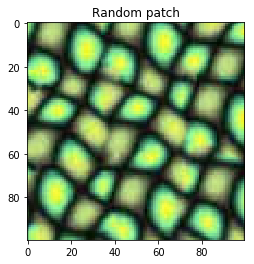

In [4]:
rand_idx = np.random.randint(len(all_blocks))
print('Random index: %d' % rand_idx)
rand_patch = all_blocks[rand_idx]
left_block = rand_patch[:, -overlap_size:]
bottom_block = rand_patch[ -overlap_size:, :]

plt.title('Random patch')
plt.imshow(normalize_img(rand_patch))
plt.show()

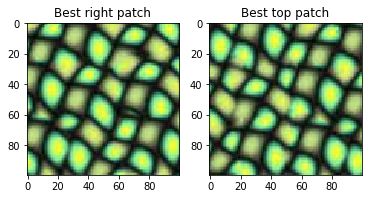

In [5]:
# horizontal case
left_cost = l2_left_right(patch_left=rand_patch, patch_right=all_blocks)
top_cost = l2_top_bottom(patch_top=rand_patch, patch_bottom=all_blocks)

best_right_patch = select_min_patch(all_blocks, left_cost)
best_top_patch = select_min_patch(all_blocks, top_cost)

best_right_block = best_right_patch[:, :overlap_size]
best_top_block = best_top_patch[:overlap_size, :]

fig, ax = plt.subplots(1,2)
ax[0].set_title('Best right patch')
ax[0].imshow(normalize_img(best_right_patch))

ax[1].set_title('Best top patch')
ax[1].imshow(normalize_img(best_top_patch))

plt.show()

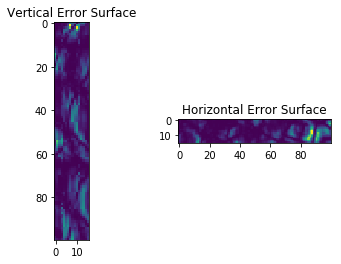

In [6]:
error_surf_vert = compute_error_surface(best_right_block, left_block)
error_surf_hor = compute_error_surface(best_top_block, bottom_block)

fig, ax = plt.subplots(1,2)
ax[0].set_title('Vertical Error Surface')
ax[0].imshow(error_surf_vert)

ax[1].set_title('Horizontal Error Surface')
ax[1].imshow(error_surf_hor)

plt.show()

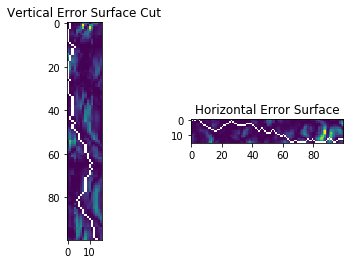

In [7]:
vert_path = min_vert_path(error_surf_vert)
vert_err_cut = error_surf_vert.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
vert_path_mask = xx.T ==  np.tile(np.expand_dims(vert_path, 1), overlap_size)
vert_err_cut[vert_path_mask] = np.nan

hor_path = min_hor_path(error_surf_hor)
hor_err_cut = error_surf_hor.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(overlap_size))
hor_path_mask = (xx.T ==  np.tile(np.expand_dims(hor_path, 1), overlap_size)).T
hor_err_cut[hor_path_mask] = np.nan

fig, ax = plt.subplots(1,2)
ax[0].set_title('Vertical Error Surface Cut')
ax[0].imshow(vert_err_cut)

ax[1].set_title('Horizontal Error Surface')
ax[1].imshow(hor_err_cut)

plt.show()

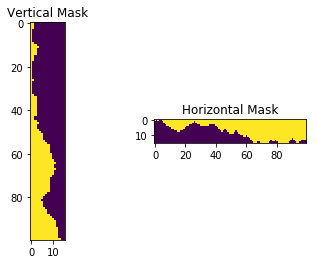

In [8]:
vert_mask = xx.T <= np.tile(np.expand_dims(vert_path, 1), overlap_size)
hor_mask = (xx.T <=  np.tile(np.expand_dims(hor_path, 1), overlap_size)).T

fig, ax = plt.subplots(1,2)
ax[0].set_title('Vertical Mask')
ax[0].imshow(vert_mask)

ax[1].set_title('Horizontal Mask')
ax[1].imshow(hor_mask)

plt.show()

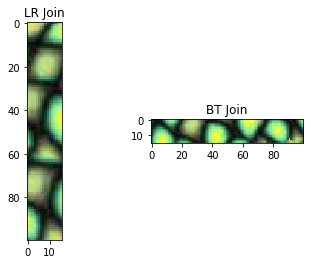

In [9]:
lr_join = np.zeros_like(left_block)
lr_join[:, :][vert_mask] = left_block[vert_mask]
lr_join[:, :][~vert_mask] = best_right_block[~vert_mask]

bt_join = np.zeros_like(bottom_block)
bt_join[:, :][hor_mask] = bottom_block[hor_mask]
bt_join[:, :][~hor_mask] = best_top_block[~hor_mask]

fig, ax = plt.subplots(1,2)
ax[0].set_title('LR Join')
ax[0].imshow(normalize_img(lr_join))

ax[1].set_title('BT Join')
ax[1].imshow(normalize_img(bt_join))

plt.show()

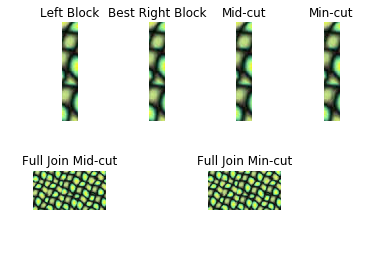

In [10]:
# join left and right blocks
left_right_join = np.hstack((left_block[:, :overlap_size//2], best_right_block[:, overlap_size//2:]))

fig, ax = plt.subplots(2, 4)

ax[0,0].imshow(normalize_img(left_block))
ax[0,0].set_title('Left Block')
ax[0,0].axis('off')

ax[0,1].imshow(normalize_img(best_right_block))
ax[0,1].set_title('Best Right Block')
ax[0,1].axis('off')

ax[0,2].imshow(normalize_img(left_right_join))
ax[0,2].set_title('Mid-cut')
ax[0,2].axis('off')

ax[0,3].imshow(normalize_img(lr_join))
ax[0,3].set_title('Min-cut')
ax[0,3].axis('off')

full_join = np.hstack((rand_patch[:, :-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))
full_join_mincut = np.hstack((rand_patch[:, :-overlap_size], lr_join, best_right_patch[:, overlap_size:]))
ax[1,0].imshow(normalize_img(full_join))
ax[1,0].set_title('Full Join Mid-cut')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,2].imshow(normalize_img(full_join_mincut))
ax[1,2].set_title('Full Join Min-cut')
ax[1,2].axis('off')
ax[1,3].axis('off')


plt.show()

r1 = 2549, r2 = 9663


C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


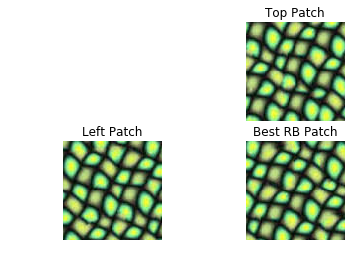

In [11]:
# now focus on L-shaped area
r1,r2 = np.random.randint(len(all_blocks), size=2)
print('r1 = %d, r2 = %d' % (r1, r2))
left_patch = all_blocks[r1]
top_patch = all_blocks[r2]

left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
best_rb_patch = select_min_patch(all_blocks, top_cost + left_cost)

fig,ax = plt.subplots(2,2)
ax[0,0].axis('off')

ax[1,0].imshow(normalize_img(left_patch))
ax[1,0].set_title('Left Patch')
ax[1,0].axis('off')

ax[0,1].imshow(normalize_img(top_patch))
ax[0,1].set_title('Top Patch')
ax[0,1].axis('off')

ax[1,1].imshow(normalize_img(best_rb_patch))
ax[1,1].set_title('Best RB Patch')
ax[1,1].axis('off')

plt.show()

C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\lo

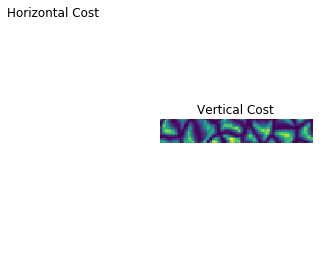

In [12]:
best_left_block  = best_rb_patch[:, :overlap_size]
best_top_block = best_rb_patch[:overlap_size, :]

right_block = left_patch[:, -overlap_size:]
bottom_block = top_patch[ -overlap_size:, :]

error_surf_hor  = compute_error_surface(best_left_block, right_block)
error_surf_vert = compute_error_surface(best_top_block, bottom_block)

fig, ax = plt.subplots(1,2)
ax[0].set_title('Horizontal Cost')
ax[0].imshow(normalize_img(error_surf_hor))
ax[0].axis('off')

ax[1].set_title('Vertical Cost')
ax[1].imshow(normalize_img(error_surf_vert))
ax[1].axis('off')

plt.show()

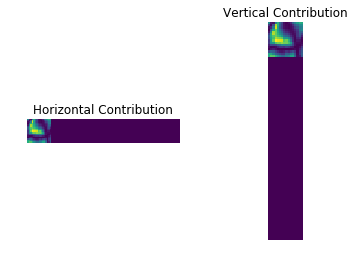

In [13]:
# compute new error surfaces (add overlap)
vert_contrib = np.zeros_like(error_surf_vert)
hor_contrib  = np.zeros_like(error_surf_hor)

vert_contrib[:, :overlap_size] += (error_surf_hor[:overlap_size, :] + error_surf_vert[:, :overlap_size])/2
hor_contrib[:overlap_size, :]  += (error_surf_vert[:, :overlap_size] + error_surf_hor[:overlap_size, :])/2

error_surf_vert += vert_contrib
error_surf_hor  += hor_contrib

fig, ax = plt.subplots(1,2)
ax[0].set_title('Horizontal Contribution')
ax[0].imshow(normalize_img(vert_contrib))
ax[0].axis('off')

ax[1].set_title('Vertical Contribution')
ax[1].imshow(normalize_img(hor_contrib))
ax[1].axis('off')

plt.show()

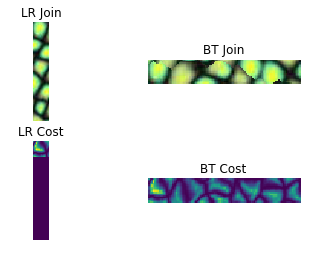

In [14]:
left_right_join = compute_lr_join(right_block, best_left_block, error_surf_vert=error_surf_hor)
bottom_top_join = compute_bt_join(bottom_block, best_top_block, error_surf_hor=error_surf_vert)

fig, ax = plt.subplots(2,2)
ax[0,0].set_title('LR Join')
ax[0,0].imshow(normalize_img(left_right_join))
ax[0,0].axis('off')

ax[1,0].set_title('LR Cost')
ax[1,0].imshow(error_surf_hor)
ax[1,0].axis('off')

ax[0,1].set_title('BT Join')
ax[0,1].imshow(normalize_img(bottom_top_join))
ax[0,1].axis('off')

ax[1,1].set_title('BT Cost')
ax[1,1].imshow(error_surf_vert)
ax[1,1].axis('off')

plt.show()

C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


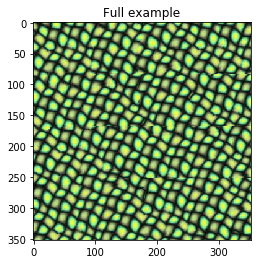

In [15]:
# now turn this into a loop:
target_height = h_new
target_width = w_new
target = np.zeros((target_height, target_width, c), dtype=texture_1.dtype)

step = block_size - overlap_size

y_begin = 0
y_end = block_size

for y in range(ny_blocks):
    
    x_begin = 0
    x_end = block_size
    
    for x in range(nx_blocks):
        if x == 0 and y == 0:
            # randomly select top left patch
            r = np.random.randint(len(all_blocks))
            random_patch = all_blocks[r]
            target[y_begin:y_end, x_begin:x_end] = random_patch
            
            x_begin = x_end
            x_end  += step
            
            continue
        
        xa, xb = x_begin - block_size, x_begin
        ya, yb = y_begin - block_size, y_begin
        
        if y == 0:
            y1 = 0
            y2 = block_size
            
            left_patch = target[y1:y2, xa:xb]
            left_block = left_patch[:, -overlap_size:]
            left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
            best_right_patch = select_min_patch(all_blocks, left_cost)
            best_right_block = best_right_patch[:, :overlap_size]
            
            left_right_join = compute_lr_join(left_block, best_right_block)
            # join left and right blocks
            full_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))

            target[y1:y2, xa:x_end] = full_join
        else:
            if x == 0:
                x1 = 0
                x2 = block_size
                top_patch = target[ya:yb, x1:x2]
                top_block = top_patch[-overlap_size:, :]
                top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
                best_bottom_patch = select_min_patch(all_blocks, top_cost)
                best_bottom_block = best_bottom_patch[:overlap_size, :]

                # join top and bottom blocks
                top_bottom_join = compute_bt_join(top_block, best_bottom_block)
                full_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                target[ya:y_end, x1:x2] = full_join
            else:
                # overlap is L-shaped
                y1, y2 = y_begin - overlap_size, y_end
                x1, x2 = x_begin - overlap_size, x_end

                left_patch = target[y1:y2, xa:xb]
                top_patch = target[ya:yb, x1:x2]
                
                left_block = left_patch[:, -overlap_size:]
                top_block = top_patch[-overlap_size:, :]
                
                left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
                top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
                
                best_right_patch = best_bottom_patch = select_min_patch(all_blocks, top_cost + left_cost)
                
                best_right_block = best_right_patch[:, :overlap_size]
                best_bottom_block = best_bottom_patch[:overlap_size, :]
                
                left_right_join, top_bottom_join = lr_bt_join_double(best_right_block, left_block, best_bottom_block, top_block)
                # join left and right blocks
                full_lr_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))
                
                # join top and bottom blocks
                full_tb_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                target[ya:y_end, x1:x2] = full_tb_join
                target[y1:y2, xa:x_end] = full_lr_join
                
        x_begin = x_end
        x_end  += step

    y_begin = y_end
    y_end  += step

plt.title('Full example')
plt.imshow(normalize_img(target))
plt.show()

In [16]:
plt.imsave('figure2c.jpg', normalize_img(target))